In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import tensorflow as tf
import imageio
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,Dense
import tensorflow.keras as keras

In [6]:
#get the soybean crops images and their corresponding labels

soybean_dataset_path = Path("/kaggle/input", "weed-detection-in-soybean-crops")
soy_images = list(soybean_dataset_path.glob(r'**/*.tif'))
soy_labels = [x.parents[0].stem for x in soy_images]

In [7]:
# get the plant seedling images and their corresponding labels

dataset_path = Path("/kaggle/input")
images = list(dataset_path.glob(r'**/*.png'))
labels = list(map(lambda x: x.parents[0].stem, images))

In [8]:
# getting the plant seedling dataset in a Dataframe for convenience

seedling_images = pd.Series(images, name="Images").astype(str)
seedling_labels = pd.Series(labels, name="Labels").astype(str)

seedling_data = pd.concat([seedling_images, seedling_labels], axis = 1)
seedling_data = seedling_data.sample(frac = 1, random_state = 42).reset_index(drop = True)
seedling_data.head()

,Images,Labels
0,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Small-flowered Cranesbill
1,/kaggle/input/v2-plant-seedlings-dataset/Commo...,Common Chickweed
2,/kaggle/input/v2-plant-seedlings-dataset/Loose...,Loose Silky-bent
3,/kaggle/input/v2-plant-seedlings-dataset/Black...,Black-grass
4,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Sugar beet


In [9]:
soy_images = pd.Series(soy_images, name="Images").astype(str)
soy_labels = pd.Series(soy_labels, name="Labels").astype(str)

soy_data = pd.concat([soy_images, soy_labels], axis=1)
soy_data = soy_data.sample(frac = 1, random_state=42).reset_index(drop = True)
soy_data.head()

,Images,Labels
0,/kaggle/input/weed-detection-in-soybean-crops/...,grass
1,/kaggle/input/weed-detection-in-soybean-crops/...,broadleaf
2,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
3,/kaggle/input/weed-detection-in-soybean-crops/...,soil
4,/kaggle/input/weed-detection-in-soybean-crops/...,soybean


In [10]:
##Concatenating the two datasets to form the final dataset
final_images = soy_data['Images'].append(seedling_data['Images'], ignore_index = True)
final_labels = soy_data['Labels'].append(seedling_data['Labels'], ignore_index = True)

final_data = pd.DataFrame(data = {'Images': final_images, 'Labels': final_labels})
display(final_data)

,Images,Labels
0,/kaggle/input/weed-detection-in-soybean-crops/...,grass
1,/kaggle/input/weed-detection-in-soybean-crops/...,broadleaf
2,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
3,/kaggle/input/weed-detection-in-soybean-crops/...,soil
4,/kaggle/input/weed-detection-in-soybean-crops/...,soybean
...,...,...
41745,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Small-flowered Cranesbill
41746,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Fat Hen
41747,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Fat Hen
41748,/kaggle/input/v2-plant-seedlings-dataset/nonse...,Scentless Mayweed


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet

train_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet.preprocess_input,
    validation_split = 0.1
)

test_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet.preprocess_input
)

In [12]:
# Create function to preprocess images
def preprocess_image(image_path):
    # Load image
    image = keras.preprocessing.image.load_img(image_path)
    
    # Convert image to array
    image_array = keras.preprocessing.image.img_to_array(image)
    
    # Normalize image
    image_array = keras.applications.mobilenet_v2.preprocess_input(image_array)
    
    return image_array

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(final_data, train_size=0.7, shuffle=True, random_state=42, stratify=final_data[["Labels"]])

train = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    fill_mode="nearest"
)

validation = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    fill_mode="nearest"
)

test = test_generator_mobile_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False
)

Found 26302 validated image filenames belonging to 16 classes.
Found 2922 validated image filenames belonging to 16 classes.
Found 12526 validated image filenames belonging to 16 classes.


In [14]:
# for the convolutional network
from keras import __version__ as keras_version
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras import losses
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

In [15]:
model = keras.Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='softmax'))

In [16]:
model.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0
: /physical_device:GPU:1


In [18]:
with tf.device('/GPU:0'):

    results = model.fit(
        train,
        validation_data = validation,
        batch_size = 32,
        epochs = 10,
        callbacks = [EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ), ReduceLROnPlateau(patience=2)]
    )

2023-01-20 17:34:16.576403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-20 17:34:18.484337: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


822/822 [==============================] - 234s 273ms/step - loss: 0.8149 - categorical_accuracy: 0.7176 - val_loss: 0.5195 - val_categorical_accuracy: 0.8196
Epoch 2/10
822/822 [==============================] - 133s 162ms/step - loss: 0.3984 - categorical_accuracy: 0.8627 - val_loss: 0.3810 - val_categorical_accuracy: 0.8734
Epoch 3/10
822/822 [==============================] - 135s 164ms/step - loss: 0.2061 - categorical_accuracy: 0.9328 - val_loss: 0.3367 - val_categorical_accuracy: 0.8980
Epoch 4/10
822/822 [==============================] - 139s 169ms/step - loss: 0.0966 - categorical_accuracy: 0.9694 - val_loss: 0.3183 - val_categorical_accuracy: 0.9196
Epoch 5/10
822/822 [==============================] - 140s 169ms/step - loss: 0.0516 - categorical_accuracy: 0.9841 - val_loss: 0.3019 - val_categorical_accuracy: 0.9350
Epoch 6/10
822/822 [==============================] - 147s 179ms/step - loss: 0.0564 - categorical_accuracy: 0.9822 - val_loss: 0.4071 - val_categorical_accuracy

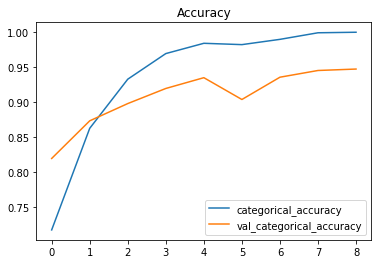

In [19]:
pd.DataFrame(results.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [20]:
model.save('kevin_cnn.h5')

In [26]:
# Testing the model
results = model.evaluate(test)

392/392 [==============================] - 56s 143ms/step - loss: 0.3300 - categorical_accuracy: 0.9267


In [22]:
predictions = np.argmax(model.predict(test), axis=1)

In [23]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

                           precision    recall  f1-score   support

              Black-grass       0.88      0.64      0.74       185
                 Charlock       0.80      0.93      0.86       271
                 Cleavers       0.86      0.87      0.87       201
         Common Chickweed       0.90      0.86      0.88       428
             Common wheat       0.80      0.67      0.73       152
                  Fat Hen       0.89      0.69      0.78       323
         Loose Silky-bent       0.86      0.84      0.85       457
                    Maize       0.71      0.91      0.80       154
        Scentless Mayweed       0.85      0.86      0.85       364
         Shepherd’s Purse       0.74      0.70      0.72       164
Small-flowered Cranesbill       0.90      0.91      0.90       346
               Sugar beet       0.69      0.86      0.77       278
                broadleaf       0.89      0.86      0.87       715
                    grass       0.93      0.93      0.93     

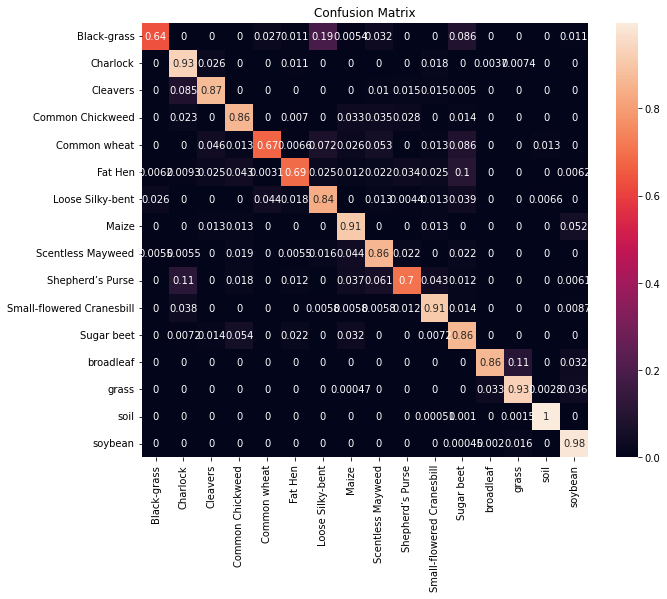

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf = confusion_matrix(actual, predictions, normalize = "true")
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, xticklabels = sorted(set(actual)), yticklabels = sorted(set(actual)))
plt.title('Confusion Matrix')
plt.show()